In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import re
import torch
import torch.nn as nn

path = [
    "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct",
    "E:/pretrained_models/Qwen/Qwen2___5-0___5B-Instruct",
    "E:/pretrained_models/LLM-Research/Llama-3___2-1B-Instruct"
]

tokenizer = AutoTokenizer.from_pretrained(
    path[0], trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    path[0], device_map="auto", torch_dtype="auto", trust_remote_code=True)
# Prepare Hook

d:\app\anaconda\envs\webui\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\app\anaconda\envs\webui\lib\site-packages\transformers\utils\hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.83s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


In [2]:
def count_zh(text: str) -> int:
    zh_pattern = re.findall(r'[\u4e00-\u9fff，。？！：；“”‘’（）《》【】]', text)
    return len(zh_pattern)

count_zh("你好，月色真美，dgmesyz:：。")

10

In [3]:
# easy test
print(
    tokenizer.decode(
        model.generate(
            inputs = tokenizer("回字有多少写法(使用中文回答)", return_tensors="pt").input_ids.to(model.device),
            max_length=256, do_sample=True, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id
        )[0], skip_special_tokens=True
    )
)


回字有多少写法(使用中文回答)

回答题具难度的多种考察方式可以包括但不限于以下几点:
1. **技术细节描述**:详细分析了解每种写法的工作原理、适用场景以及区别如何。
2. **情景应用**:为了掌握技术之外的能力,你能在给定的或相关的情景下怎样选择合适的写法。
3. **性能与效率**:考察了解每种方法对资源消耗的影响及是否适合长期使用或高水平应用。
4. **安全考量**:对各种写法是否具备适应安全需求(例如�


In [4]:
print(model)

ExaoneForCausalLM(
  (transformer): ExaoneModel(
    (wte): Embedding(102400, 2560, padding_idx=0)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-29): 30 x ExaoneBlock(
        (ln_1): ExaoneRMSNorm()
        (attn): ExaoneAttention(
          (attention): ExaoneSdpaAttention(
            (rotary): ExaoneRotaryEmbedding()
            (k_proj): Linear(in_features=2560, out_features=640, bias=False)
            (v_proj): Linear(in_features=2560, out_features=640, bias=False)
            (q_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (out_proj): Linear(in_features=2560, out_features=2560, bias=False)
          )
        )
        (ln_2): ExaoneRMSNorm()
        (mlp): ExaoneGatedMLP(
          (c_fc_0): Linear(in_features=2560, out_features=7168, bias=False)
          (c_fc_1): Linear(in_features=2560, out_features=7168, bias=False)
          (c_proj): Linear(in_features=7168, out_features=2560, bias=False)
          (act): SiLU()
  

In [6]:
from transformers.models.llama.modeling_llama import LlamaDecoderLayer
from transformers.models.qwen2.modeling_qwen2 import Qwen2DecoderLayer
from typing import Union

NUM_LAYERS = model.config.num_hidden_layers

zh_table, al_table, zh_num = [0] * NUM_LAYERS, [0] * NUM_LAYERS, [0]
hooks = []


@torch.inference_mode()
def hook(modules: nn.Module, inp, out, **kwargs):
    # ref from modelling_llama.py
    if not isinstance(modules, Union[LlamaDecoderLayer, Qwen2DecoderLayer]):
        raise ValueError(f"hook must be registered on LlamaDecoderLayer, got {modules._get_name()}")
    prefix = kwargs.get("prefix", None)
    if prefix is None:
        raise ValueError("hook must have a name")
    with torch.no_grad():
        hidden_states = out[0].detach().clone()
        if hidden_states.device != model.device:
            hidden_states = hidden_states.to(model.device)
        
        # print(hidden_states.shape)
        hidden_states = model.model.norm(hidden_states)
        logits = model.lm_head(hidden_states)
        input_ids = logits.argmax(dim=-1)
        
        zh, al = 0, 0
        for id in input_ids[0]:
            generate_str = tokenizer.decode(
                id, skip_special_tokens=True)   
            zh += count_zh(generate_str)
            al += 1
        # print(
        #     repr(f"layer: {prefix}, generate: {generate_str}, count_zh: {zh}, length: {al}"))
        layer_num = int(prefix.split(".")[-1])
        zh_table[layer_num] += zh
        al_table[layer_num] += al
    return out

pattern = re.compile(r".*layers\.\d*$")

for name, module in model.named_modules():
    if re.match(pattern, name):
        hooks.append(
            module.register_forward_hook(
                hook=lambda modules, inp, out, prefix=name: hook(modules, inp, out, prefix=prefix)
        ))
        
        
from datasets import load_dataset
ds = load_dataset("E:/datasets/mgsm", "zh", trust_remote_code=True)

text = ds["train"]["question"]

tokenizer.pad_token = tokenizer.eos_token
for t in text:
    print(t)
    x = model(**tokenizer(t, return_tensors="pt", add_special_tokens=False).to(model.device)).logits
    x = x.argmax(dim=-1).squeeze(0)
    # print(tokenizer.decode(x, skip_special_tokens=True))
# print(string)
for hook_ in hooks:
    hook_.remove()
print([f"Layer {i}: {zh_table[i]}/{al_table[i]}" for i in range(len(zh_table))])
# print(
#     f"generate zh_word {count_zh(string)} and greedy zh_word {zh_num[0]}"
# )

问题：罗杰有 5 个网球。他又买了 2 罐网球。每罐有 3 个网球。他现在有多少个网球？
问题：服务器机房里有九台电脑。从周一到周四，每天又安装了五台电脑。服务器机房里现在有多少台电脑？
问题：利亚有 32 块巧克力，她妹妹有 42 块。如果她们吃了 35 块，她们一共还剩下多少块？
问题：肖恩有五个玩具。圣诞节他从他爸爸妈妈那里各得到了两个玩具。他现在有多少个玩具？
问题：迈克尔有 58 个高尔夫球。周二，他丢失了 23 个高尔夫球。周三，他又丢失了 2 个。周三结束时他有多少个高尔夫球？
问题：奥利维亚有 23 美元。她买了五个单价 3 美元的百吉饼。她还剩多少钱？
问题：杰森有 20 根棒棒糖。他给了丹尼一些棒棒糖。现在杰森有 12 根棒棒糖。杰森给了丹尼多少根棒棒糖？
问题：如果停车场里有 3 辆车，又来了 2 辆车，停车场里有多少辆车？
['Layer 0: 128/285', 'Layer 1: 97/285', 'Layer 2: 95/285', 'Layer 3: 91/285', 'Layer 4: 65/285', 'Layer 5: 96/285', 'Layer 6: 62/285', 'Layer 7: 79/285', 'Layer 8: 81/285', 'Layer 9: 80/285', 'Layer 10: 110/285', 'Layer 11: 125/285', 'Layer 12: 136/285', 'Layer 13: 146/285', 'Layer 14: 166/285', 'Layer 15: 160/285', 'Layer 16: 202/285', 'Layer 17: 131/285', 'Layer 18: 171/285', 'Layer 19: 224/285', 'Layer 20: 274/285', 'Layer 21: 325/285', 'Layer 22: 321/285', 'Layer 23: 276/285']


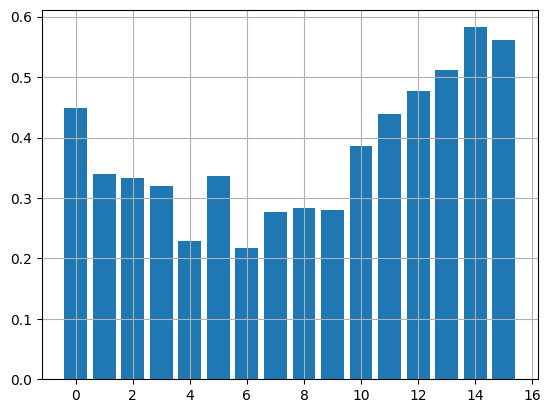

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.bar(np.arange(16), [zh_table[i]/al_table[i] for i in range(16)], label="zh_word/length")
ax.grid()